In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install pydicom
!pip install nibabel


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import pydicom
import os


In [8]:
import pandas as pd
import os
import json
import pydicom

class DatasetCompletenessChecker:
    def __init__(self, metadata_path, annotations_path, metadata_format="csv", annotations_format="csv"):
        """
        Initialize with paths to metadata and annotations, supporting multiple formats.
        :param metadata_path: Path to the metadata file (CSV, Excel, or directory for DICOM).
        :param annotations_path: Path to the annotations file (CSV, Excel, TXT, JSON, or directory for segmentation masks).
        :param metadata_format: Format of the metadata file ('csv', 'excel', 'dicom').
        :param annotations_format: Format of the annotations file ('csv', 'excel', 'txt', 'json', 'png', 'nii').
        """
        self.metadata = self.load_data(metadata_path, metadata_format, is_metadata=True)
        self.annotations = self.load_data(annotations_path, annotations_format, is_metadata=False)

    def load_data(self, path, data_format, is_metadata):
        """
        Load data based on the specified format.
        :param path: File or directory path.
        :param data_format: Format of the data ('csv', 'excel', 'dicom', 'txt', 'json', 'png', 'nii').
        :param is_metadata: Boolean flag to differentiate metadata from annotations.
        :return: A pandas DataFrame or list of files containing the loaded data.
        """
        if data_format == "csv":
            return pd.read_csv(path)
        elif data_format == "excel":
            return pd.read_excel(path)
        elif data_format == "dicom":
            return self.load_dicom_metadata(path)
        elif data_format == "txt":
            return self.load_txt_annotations(path) if not is_metadata else None
        elif data_format == "json":
            return self.load_json_annotations(path) if not is_metadata else None
        elif data_format in ["png", "nii"]:
            return self.load_image_annotations(path, data_format) if not is_metadata else None
        else:
            raise ValueError(f"Unsupported format: {data_format}")

    def load_dicom_metadata(self, directory):
        """
        Extract metadata from DICOM files in a directory.
        :param directory: Path to the directory containing DICOM files.
        :return: A pandas DataFrame with extracted metadata.
        """
        metadata_records = []
        for file in os.listdir(directory):
            if file.endswith(".dcm"):
                dicom_path = os.path.join(directory, file)
                dicom_data = pydicom.dcmread(dicom_path)
                metadata = {
                    "PatientID": getattr(dicom_data, "PatientID", None),
                    "StudyDate": getattr(dicom_data, "StudyDate", None),
                    "Modality": getattr(dicom_data, "Modality", None),
                    "FileName": file,
                }
                metadata_records.append(metadata)
        return pd.DataFrame(metadata_records)

    def load_txt_annotations(self, directory):
        """
        Load annotations from TXT files in a directory.
        :param directory: Path to the directory containing TXT files.
        :return: A list of dictionaries with annotations.
        """
        annotations = []
        for file in os.listdir(directory):
            if file.endswith(".txt"):
                file_path = os.path.join(directory, file)
                with open(file_path, "r") as f:
                    content = f.read().strip()
                    annotations.append({"file": file, "content": content})
        return pd.DataFrame(annotations)

    def load_json_annotations(self, path):
        """
        Load annotations from a JSON file.
        :param path: Path to the JSON file.
        :return: A pandas DataFrame containing annotations.
        """
        with open(path, "r") as f:
            data = json.load(f)
        return pd.DataFrame(data.get("annotations", []))

    def load_image_annotations(self, directory, format):
        """
        Load image-based annotations (e.g., PNG masks or NIFTI files).
        :param directory: Path to the directory containing image annotation files.
        :param format: Format of the image files ('png' or 'nii').
        :return: A list of file paths.
        """
        return [file for file in os.listdir(directory) if file.endswith(format)]

    def assess_metadata_completeness(self, required_fields):
        """
        Assess metadata completeness for the dataset.
        :param required_fields: A list of required metadata fields.
        :return: Metadata completeness score.
        """
        present_fields = sum([1 for field in required_fields if field in self.metadata.columns])
        completeness_score = (present_fields / len(required_fields)) * 100
        return completeness_score

    def assess_annotation_completeness(self, required_annotations):
        """
        Assess annotation completeness for the dataset.
        :param required_annotations: A list of required annotations.
        :return: Annotation completeness score.
        """
        if isinstance(self.annotations, pd.DataFrame):
            present_annotations = sum([1 for annotation in required_annotations if annotation in self.annotations.columns])
        else:
            present_annotations = len(self.annotations)
        completeness_score = (present_annotations / len(required_annotations)) * 100
        return completeness_score

    def assess_combined_completeness(self, required_fields, required_annotations):
        """
        Assess combined metadata and annotation completeness for the dataset.
        :param required_fields: List of required metadata fields.
        :param required_annotations: List of required annotations.
        :return: A dictionary with metadata, annotation, and combined completeness scores.
        """
        metadata_score = self.assess_metadata_completeness(required_fields)
        annotation_score = self.assess_annotation_completeness(required_annotations)
        overall_score = (metadata_score + annotation_score) / 2

        return {
            "Metadata Completeness": metadata_score,
            "Annotation Completeness": annotation_score,
            "Overall Completeness": overall_score
        }

# Example usage
metadata_path = "simulated_data/metadata.csv"  # Replace with your path
annotations_path = "synthetic_annotations/localization/json/localization.json"  # Replace with your path
required_metadata = ["PatientID", "StudyDate", "Modality"]
required_annotations = ["segmentation_mask", "bounding_box"]

# Initialize with supported formats
checker = DatasetCompletenessChecker(metadata_path, annotations_path, metadata_format="csv", annotations_format="json")

# Assess completeness
combined_completeness = checker.assess_combined_completeness(required_metadata, required_annotations)
print("Combined Completeness:", combined_completeness)


Combined Completeness: {'Metadata Completeness': 33.33333333333333, 'Annotation Completeness': 0.0, 'Overall Completeness': 16.666666666666664}


Combined Completeness: {'Metadata Completeness': {'completeness_score': 33.333333333333336, 'missing_data': {'PatientID': 0, 'StudyDate': 100, 'Modality': 100}, 'total_missing': 200}, 'Annotation Completeness': {'completeness_score': 0.0, 'missing_annotations': {'segmentation_mask': 10, 'bounding_box': 10}, 'total_missing': 20}, 'Overall Completeness Score': 16.666666666666668}


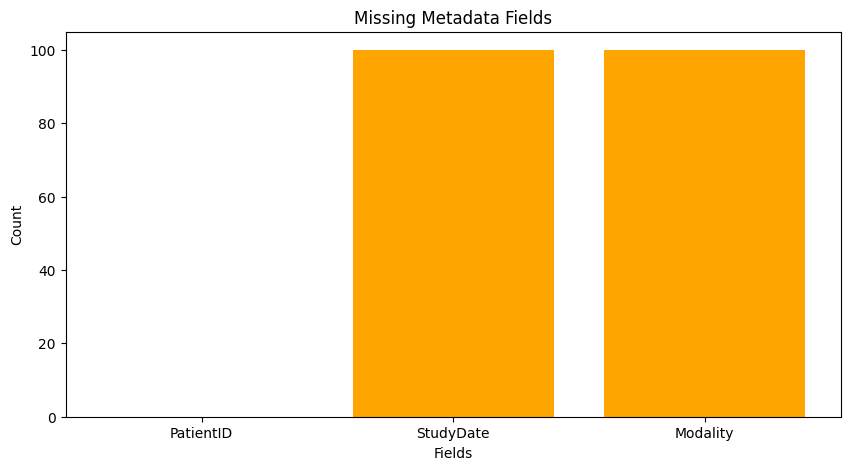

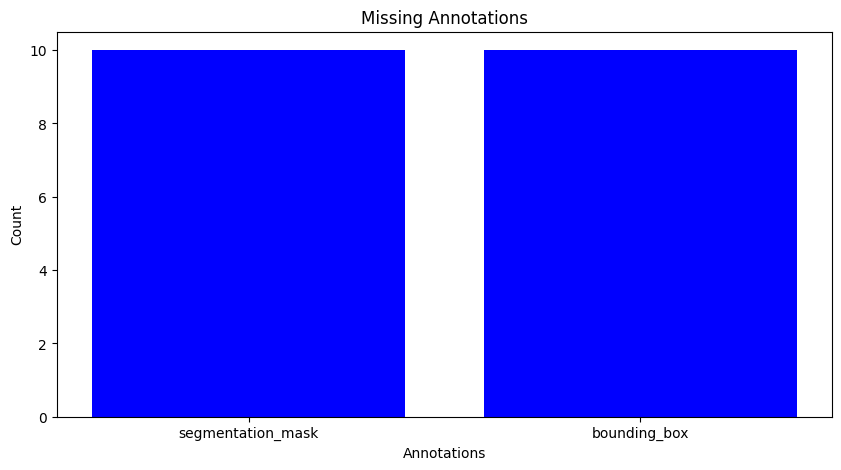

In [9]:
import pandas as pd
import os
import json
import pydicom

class DatasetCompletenessChecker:
    def __init__(self, metadata_path, annotations_path, metadata_format="csv", annotations_format="csv"):
        """
        Initialize with paths to metadata and annotations, supporting multiple formats.
        :param metadata_path: Path to the metadata file (CSV, Excel, or directory for DICOM).
        :param annotations_path: Path to the annotations file (CSV, Excel, TXT, JSON, or directory for segmentation masks).
        :param metadata_format: Format of the metadata file ('csv', 'excel', 'dicom').
        :param annotations_format: Format of the annotations file ('csv', 'excel', 'txt', 'json', 'png', 'nii').
        """
        self.metadata = self.load_data(metadata_path, metadata_format, is_metadata=True)
        self.annotations = self.load_data(annotations_path, annotations_format, is_metadata=False)

    def load_data(self, path, data_format, is_metadata):
        """
        Load data based on the specified format.
        :param path: File or directory path.
        :param data_format: Format of the data ('csv', 'excel', 'dicom', 'txt', 'json', 'png', 'nii').
        :param is_metadata: Boolean flag to differentiate metadata from annotations.
        :return: A pandas DataFrame or list of files containing the loaded data.
        """
        if data_format == "csv":
            return pd.read_csv(path)
        elif data_format == "excel":
            return pd.read_excel(path)
        elif data_format == "dicom":
            return self.load_dicom_metadata(path)
        elif data_format == "txt":
            return self.load_txt_annotations(path) if not is_metadata else None
        elif data_format == "json":
            return self.load_json_annotations(path) if not is_metadata else None
        elif data_format in ["png", "nii"]:
            return self.load_image_annotations(path, data_format) if not is_metadata else None
        else:
            raise ValueError(f"Unsupported format: {data_format}")

    def load_dicom_metadata(self, directory):
        """
        Extract metadata from DICOM files in a directory.
        :param directory: Path to the directory containing DICOM files.
        :return: A pandas DataFrame with extracted metadata.
        """
        metadata_records = []
        for file in os.listdir(directory):
            if file.endswith(".dcm"):
                dicom_path = os.path.join(directory, file)
                dicom_data = pydicom.dcmread(dicom_path)
                metadata = {
                    "PatientID": getattr(dicom_data, "PatientID", None),
                    "StudyDate": getattr(dicom_data, "StudyDate", None),
                    "Modality": getattr(dicom_data, "Modality", None),
                    "FileName": file,
                }
                metadata_records.append(metadata)
        return pd.DataFrame(metadata_records)

    def load_txt_annotations(self, directory):
        """
        Load annotations from TXT files in a directory.
        :param directory: Path to the directory containing TXT files.
        :return: A list of dictionaries with annotations.
        """
        annotations = []
        for file in os.listdir(directory):
            if file.endswith(".txt"):
                file_path = os.path.join(directory, file)
                with open(file_path, "r") as f:
                    content = f.read().strip()
                    annotations.append({"file": file, "content": content})
        return pd.DataFrame(annotations)

    def load_json_annotations(self, path):
        """
        Load annotations from a JSON file.
        :param path: Path to the JSON file.
        :return: A pandas DataFrame containing annotations.
        """
        with open(path, "r") as f:
            data = json.load(f)
        return pd.DataFrame(data.get("annotations", []))

    def load_image_annotations(self, directory, format):
        """
        Load image-based annotations (e.g., PNG masks or NIFTI files).
        :param directory: Path to the directory containing image annotation files.
        :param format: Format of the image files ('png' or 'nii').
        :return: A list of file paths.
        """
        return [file for file in os.listdir(directory) if file.endswith(format)]

    def assess_metadata_completeness(self, required_fields):
        """
        Assess metadata completeness for the dataset.
        :param required_fields: A list of required metadata fields.
        :return: Detailed metadata completeness report.
        """
        missing_data = {field: self.metadata[field].isnull().sum() if field in self.metadata.columns else len(self.metadata)
                        for field in required_fields}
        total_missing = sum(missing_data.values())
        completeness_score = (1 - total_missing / (len(required_fields) * len(self.metadata))) * 100
        return {
            "completeness_score": completeness_score,
            "missing_data": missing_data,
            "total_missing": total_missing
        }

    def assess_annotation_completeness(self, required_annotations):
        """
        Assess annotation completeness for the dataset.
        :param required_annotations: A list of required annotations.
        :return: Detailed annotation completeness report.
        """
        missing_annotations = {annotation: len(self.annotations) if annotation not in self.annotations.columns else 0
                                for annotation in required_annotations}
        total_missing = sum(missing_annotations.values())
        completeness_score = (1 - total_missing / (len(required_annotations) * len(self.annotations))) * 100
        return {
            "completeness_score": completeness_score,
            "missing_annotations": missing_annotations,
            "total_missing": total_missing
        }

    def assess_combined_completeness(self, required_fields, required_annotations):
        """
        Assess combined metadata and annotation completeness for the dataset.
        :param required_fields: List of required metadata fields.
        :param required_annotations: List of required annotations.
        :return: A detailed combined completeness report.
        """
        metadata_report = self.assess_metadata_completeness(required_fields)
        annotation_report = self.assess_annotation_completeness(required_annotations)

        overall_completeness_score = (metadata_report["completeness_score"] + annotation_report["completeness_score"]) / 2

        return {
            "Metadata Completeness": metadata_report,
            "Annotation Completeness": annotation_report,
            "Overall Completeness Score": overall_completeness_score
        }

    def visualize_completeness(self, report):
        """
        Visualize the completeness report using bar charts.
        :param report: The combined completeness report.
        """
        import matplotlib.pyplot as plt

        # Metadata missing data visualization
        metadata_missing = report["Metadata Completeness"]["missing_data"]
        plt.figure(figsize=(10, 5))
        plt.bar(metadata_missing.keys(), metadata_missing.values(), color="orange")
        plt.title("Missing Metadata Fields")
        plt.xlabel("Fields")
        plt.ylabel("Count")
        plt.show()

        # Annotation missing data visualization
        annotation_missing = report["Annotation Completeness"]["missing_annotations"]
        plt.figure(figsize=(10, 5))
        plt.bar(annotation_missing.keys(), annotation_missing.values(), color="blue")
        plt.title("Missing Annotations")
        plt.xlabel("Annotations")
        plt.ylabel("Count")
        plt.show()


# Example usage
metadata_path = "simulated_data/metadata.csv"  # Replace with your path
annotations_path = "synthetic_annotations/localization/json/localization.json"  # Replace with your path
required_metadata = ["PatientID", "StudyDate", "Modality"]
required_annotations = ["segmentation_mask", "bounding_box"]


# Initialize with supported formats
checker = DatasetCompletenessChecker(metadata_path, annotations_path, metadata_format="csv", annotations_format="json")

# Assess completeness
combined_completeness = checker.assess_combined_completeness(required_metadata, required_annotations)
print("Combined Completeness:", combined_completeness)

# Visualize completeness
checker.visualize_completeness(combined_completeness)


In [5]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

# Ensure directories for simulated data
os.makedirs("simulated_data/DICOM", exist_ok=True)
os.makedirs("simulated_data/annotations/localization", exist_ok=True)
os.makedirs("simulated_data/annotations/segmentation", exist_ok=True)
os.makedirs("simulated_data/annotations/classification", exist_ok=True)

# Create metadata.csv with incomplete information
np.random.seed(42)
metadata = {
    "PatientID": [f"Patient_{i+1}" for i in range(100)],
    "Age": [np.random.choice([25, 30, 35, np.nan]) for _ in range(100)],
    "Gender": [np.random.choice(["M", "F", np.nan]) for _ in range(100)],
    "ZipCode": [np.random.choice([10001, 20002, 30003, np.nan]) for _ in range(100)],
    "Race": [np.random.choice(["White", "Black", "Asian", "Hispanic", np.nan]) for _ in range(100)],
}
metadata_df = pd.DataFrame(metadata)
metadata_csv_path = "simulated_data/metadata.csv"
metadata_df.to_csv(metadata_csv_path, index=False)

# Create DICOM metadata placeholders
dicom_metadata = []
for i, row in metadata_df.iterrows():
    dicom_metadata.append({
        "PatientID": row["PatientID"],
        "Age": row["Age"] if not pd.isnull(row["Age"]) else None,
        "Gender": row["Gender"] if not pd.isnull(row["Gender"]) else None,
        "ZipCode": row["ZipCode"] if not pd.isnull(row["ZipCode"]) else None,
        "Race": row["Race"] if not pd.isnull(row["Race"]) else None,
        "FileName": f"Patient_{i+1}.dcm",
    })

dicom_metadata_df = pd.DataFrame(dicom_metadata)
dicom_metadata_df.to_csv("simulated_data/DICOM/dicom_metadata.csv", index=False)

# Create annotations
# Localization: Ensure ROI files exist for most images
for i in range(100):
    if i % 3 != 0:  # Make some missing
        roi_file_path = f"simulated_data/annotations/localization/Patient_{i+1}_ROI.txt"
        with open(roi_file_path, "w") as f:
            f.write(f"ROI coordinates for Patient_{i+1}")

# Segmentation: Ensure binary mask images exist for most images
for i in range(100):
    if i % 4 != 0:  # Make some missing
        mask_file_path = f"simulated_data/annotations/segmentation/Patient_{i+1}_Mask.png"
        with open(mask_file_path, "w") as f:
            f.write(f"Binary mask for Patient_{i+1}")

# Classification: Ensure labels exist for all images
classification_labels = {
    "PatientID": [f"Patient_{i+1}" for i in range(100)],
    "Label": [np.random.choice(["ClassA", "ClassB", "ClassC", np.nan]) for _ in range(100)],
}
classification_labels_df = pd.DataFrame(classification_labels)
classification_excel_path = "simulated_data/annotations/classification/labels.xlsx"
classification_labels_df.to_excel(classification_excel_path, index=False)

# Function to loop through annotation folders
def check_annotations(annotation_folder):
    missing_annotations = []
    for i in range(100):
        patient_id = f"Patient_{i+1}"
        roi_path = os.path.join(annotation_folder, "localization", f"{patient_id}_ROI.txt")
        mask_path = os.path.join(annotation_folder, "segmentation", f"{patient_id}_Mask.png")
        if not os.path.exists(roi_path):
            missing_annotations.append(f"Missing ROI for {patient_id}")
        if not os.path.exists(mask_path):
            missing_annotations.append(f"Missing Mask for {patient_id}")
    return missing_annotations

# Run annotation check
missing_annotations = check_annotations("simulated_data/annotations")

# Output summary
print("Simulated data generated:")
print(f"- Metadata CSV: {metadata_csv_path}")
print(f"- DICOM metadata CSV: simulated_data/DICOM/dicom_metadata.csv")
print(f"- Localization ROI directory: simulated_data/annotations/localization")
print(f"- Segmentation masks directory: simulated_data/annotations/segmentation")
print(f"- Classification labels Excel: {classification_excel_path}")
print("\nMissing Annotations:")
print("\n".join(missing_annotations[:10]), "...")  # Show only first 10 missing annotations for brevity


Simulated data generated:
- Metadata CSV: simulated_data/metadata.csv
- DICOM metadata CSV: simulated_data/DICOM/dicom_metadata.csv
- Localization ROI directory: simulated_data/annotations/localization
- Segmentation masks directory: simulated_data/annotations/segmentation
- Classification labels Excel: simulated_data/annotations/classification/labels.xlsx

Missing Annotations:
Missing ROI for Patient_1
Missing Mask for Patient_1
Missing ROI for Patient_4
Missing Mask for Patient_5
Missing ROI for Patient_7
Missing Mask for Patient_9
Missing ROI for Patient_10
Missing ROI for Patient_13
Missing Mask for Patient_13
Missing ROI for Patient_16 ...


In [6]:
import numpy as np
import cv2
import json
import nibabel as nib
import os

# Create directories for synthetic annotations
os.makedirs("synthetic_annotations/localization/csv", exist_ok=True)
os.makedirs("synthetic_annotations/localization/json", exist_ok=True)
os.makedirs("synthetic_annotations/localization/txt", exist_ok=True)
os.makedirs("synthetic_annotations/segmentation/png", exist_ok=True)
os.makedirs("synthetic_annotations/segmentation/json", exist_ok=True)
os.makedirs("synthetic_annotations/segmentation/nii", exist_ok=True)

# Number of synthetic samples
num_samples = 10

# Dimensions of images/masks
image_height, image_width = 256, 256

# Generate Localization Annotations
localization_csv_data = []
localization_json_data = {"annotations": []}

for i in range(1, num_samples + 1):
    image_id = f"image_{i}"
    x_min = np.random.randint(0, image_width // 2)
    y_min = np.random.randint(0, image_height // 2)
    x_max = np.random.randint(image_width // 2, image_width)
    y_max = np.random.randint(image_height // 2, image_height)
    coordinates = [x_min, y_min, x_max, y_max]

    # Save to CSV format
    localization_csv_data.append({"image_id": image_id, "x_min": x_min, "y_min": y_min, "x_max": x_max, "y_max": y_max})

    # Save to JSON format
    localization_json_data["annotations"].append({"image_id": image_id, "bbox": coordinates})

    # Save to TXT format
    txt_file_path = f"synthetic_annotations/localization/txt/{image_id}_bbox.txt"
    with open(txt_file_path, "w") as f:
        f.write(",".join(map(str, coordinates)))

# Write Localization CSV
localization_csv_path = "synthetic_annotations/localization/csv/localization.csv"
localization_csv_df = pd.DataFrame(localization_csv_data)
localization_csv_df.to_csv(localization_csv_path, index=False)

# Write Localization JSON
localization_json_path = "synthetic_annotations/localization/json/localization.json"
with open(localization_json_path, "w") as f:
    json.dump(localization_json_data, f, indent=4)

# Generate Segmentation Annotations
for i in range(1, num_samples + 1):
    # Create binary mask
    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    x_min = np.random.randint(50, image_width // 2)
    y_min = np.random.randint(50, image_height // 2)
    x_max = x_min + np.random.randint(20, 50)
    y_max = y_min + np.random.randint(20, 50)
    mask[y_min:y_max, x_min:x_max] = 255  # Create a white region

    # Save as PNG
    png_file_path = f"synthetic_annotations/segmentation/png/image_{i}_mask.png"
    cv2.imwrite(png_file_path, mask)

    # Save as JSON (COCO-style segmentation)
    segmentation_json_data = {
        "image_id": f"image_{i}",
        "segmentation": [x_min, y_min, x_max, y_min, x_max, y_max, x_min, y_max],
        "category_id": 1,
    }
    json_file_path = f"synthetic_annotations/segmentation/json/image_{i}_segmentation.json"
    with open(json_file_path, "w") as f:
        json.dump(segmentation_json_data, f, indent=4)

    # Save as NIFTI (.nii)
    nii_file_path = f"synthetic_annotations/segmentation/nii/image_{i}_mask.nii"
    mask_nifti = nib.Nifti1Image(mask, affine=np.eye(4))
    nib.save(mask_nifti, nii_file_path)

# Summary of Generated Data
print("Synthetic annotations generated:")
print(f"- Localization CSV: {localization_csv_path}")
print(f"- Localization JSON: {localization_json_path}")
print(f"- Localization TXT Directory: synthetic_annotations/localization/txt")
print(f"- Segmentation PNG Directory: synthetic_annotations/segmentation/png")
print(f"- Segmentation JSON Directory: synthetic_annotations/segmentation/json")
print(f"- Segmentation NIFTI Directory: synthetic_annotations/segmentation/nii")


Synthetic annotations generated:
- Localization CSV: synthetic_annotations/localization/csv/localization.csv
- Localization JSON: synthetic_annotations/localization/json/localization.json
- Localization TXT Directory: synthetic_annotations/localization/txt
- Segmentation PNG Directory: synthetic_annotations/segmentation/png
- Segmentation JSON Directory: synthetic_annotations/segmentation/json
- Segmentation NIFTI Directory: synthetic_annotations/segmentation/nii


In [7]:
import os
import pandas as pd
import numpy as np
import json

# Create directories for classification and regression annotations
os.makedirs("synthetic_annotations/classification/csv", exist_ok=True)
os.makedirs("synthetic_annotations/classification/json", exist_ok=True)
os.makedirs("synthetic_annotations/classification/txt", exist_ok=True)
os.makedirs("synthetic_annotations/regression/csv", exist_ok=True)
os.makedirs("synthetic_annotations/regression/json", exist_ok=True)
os.makedirs("synthetic_annotations/regression/txt", exist_ok=True)

# Number of samples
num_samples = 10

# Generate Classification Labels
classification_data_csv = []
classification_data_json = {"annotations": []}

for i in range(1, num_samples + 1):
    image_id = f"image_{i}"
    label = np.random.choice(["ClassA", "ClassB", "ClassC"])

    # Save to CSV format
    classification_data_csv.append({"image_id": image_id, "label": label})

    # Save to JSON format
    classification_data_json["annotations"].append({"image_id": image_id, "label": label})

    # Save to TXT format
    txt_file_path = f"synthetic_annotations/classification/txt/{image_id}_label.txt"
    with open(txt_file_path, "w") as f:
        f.write(label)

# Write Classification CSV
classification_csv_path = "synthetic_annotations/classification/csv/classification.csv"
classification_csv_df = pd.DataFrame(classification_data_csv)
classification_csv_df.to_csv(classification_csv_path, index=False)

# Write Classification JSON
classification_json_path = "synthetic_annotations/classification/json/classification.json"
with open(classification_json_path, "w") as f:
    json.dump(classification_data_json, f, indent=4)

# Generate Regression Labels
regression_data_csv = []
regression_data_json = {"annotations": []}

for i in range(1, num_samples + 1):
    image_id = f"image_{i}"
    value = np.random.uniform(0, 100)  # Simulate a continuous value for regression

    # Save to CSV format
    regression_data_csv.append({"image_id": image_id, "value": value})

    # Save to JSON format
    regression_data_json["annotations"].append({"image_id": image_id, "value": value})

    # Save to TXT format
    txt_file_path = f"synthetic_annotations/regression/txt/{image_id}_value.txt"
    with open(txt_file_path, "w") as f:
        f.write(str(value))

# Write Regression CSV
regression_csv_path = "synthetic_annotations/regression/csv/regression.csv"
regression_csv_df = pd.DataFrame(regression_data_csv)
regression_csv_df.to_csv(regression_csv_path, index=False)

# Write Regression JSON
regression_json_path = "synthetic_annotations/regression/json/regression.json"
with open(regression_json_path, "w") as f:
    json.dump(regression_data_json, f, indent=4)

# Summary of Generated Data
print("Synthetic classification and regression annotations generated:")
print(f"- Classification CSV: {classification_csv_path}")
print(f"- Classification JSON: {classification_json_path}")
print(f"- Classification TXT Directory: synthetic_annotations/classification/txt")
print(f"- Regression CSV: {regression_csv_path}")
print(f"- Regression JSON: {regression_json_path}")
print(f"- Regression TXT Directory: synthetic_annotations/regression/txt")


Synthetic classification and regression annotations generated:
- Classification CSV: synthetic_annotations/classification/csv/classification.csv
- Classification JSON: synthetic_annotations/classification/json/classification.json
- Classification TXT Directory: synthetic_annotations/classification/txt
- Regression CSV: synthetic_annotations/regression/csv/regression.csv
- Regression JSON: synthetic_annotations/regression/json/regression.json
- Regression TXT Directory: synthetic_annotations/regression/txt
